### INSTRUCTION

You should have run `scripts/03_model.sh` to get the `grn.csv` file. You do not have to run script #04 to #06 before this script

You should set the predicted grn file below

You should make sure the workspace is `scripts/`

In [1]:
def change_into_current_py_path():
    import os
    current_dir = os.path.dirname(__file__)
    os.chdir(current_dir)

change_into_current_py_path()

#TODO:
grnfile = "../test/model_test/normal_1/grn.csv"

### Get started

In [2]:
import pandas as pd
import numpy as np

from ctxcore.genesig import GeneSignature
from pyscenic.aucell import aucell

import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
grn = pd.read_csv(grnfile)
display(grn)

grn_table = grn.pivot_table(index="Gene2", columns="Gene1", values="EdgeWeight", fill_value=0)
grn_table = (grn_table.values.mean(axis=1)**(-1)).reshape(-1,1) * grn_table * grn_table.values.mean(axis=0)**(-1)

k_tar, k_tf = int(grn_table.shape[0]*0.50), 20

mask_target = np.zeros_like(grn_table.values)
mask_target[grn_table.values.argsort(axis=0)[-k_tar:, :], 
            np.tile(np.arange(grn_table.shape[1]), (k_tar, 1))] = 1    # 每个TF最相关的target

mask_tf = np.zeros_like(grn_table.values)
mask_tf[np.tile(np.arange(grn_table.shape[0]).reshape(-1,1), (1, k_tf)), 
        grn_table.values.argsort(axis=1)[:, -k_tf:]] = 1    # 每个target最相关的TF

masked_grn = mask_target*mask_tf*grn_table.values
notModu = np.where((masked_grn!=0).sum(axis=0)<20)[0]
masked_grn[:, notModu] = 0
tfs = np.where((masked_grn!=0).sum(axis=0)!=0)[0]

print(f"Module number: {len(tfs)}")
print(f"Edge number: {(masked_grn!=0).sum()}")

,Gene1,Gene2,EdgeWeight,weight_abs
0,TAF1,JUN,1427.703700,1427.703700
1,JUN,TAF1,1427.703700,1427.703700
2,JUN,MYC,1424.186600,1424.186600
3,MYC,JUN,1424.186600,1424.186600
4,TAF1,MYC,1420.425300,1420.425300
...,...,...,...,...
1000833,ZFP275,MIR466G,0.389247,0.389247
1000834,RHOX6,GM15459,0.385304,0.385304
1000835,RHOX6,GM15432,0.101649,0.101649
1000836,ZFP275,MIR466F-2,0.087809,0.087809


Module number: 123
Edge number: 28263


In [3]:
# grn = pd.read_csv("../data/mESC/GroundTruth.csv")
# display(grn)

# grn.loc[:, 'EdgeWeight'] = 1
# grn_table = grn.pivot_table(index="Gene2", columns="Gene1", values="EdgeWeight", fill_value=0)

# masked_grn = grn_table.values
# notModu = np.where((masked_grn!=0).sum(axis=0)<20)[0]
# masked_grn[:, notModu] = 0
# tfs = np.where((masked_grn!=0).sum(axis=0)!=0)[0]

# print(f"Module number: {len(tfs)}")
# print(f"Edge number: {(masked_grn!=0).sum()}")

In [4]:
# input: grn_table, masked_grn, tfs
_modules = [{'name': grn_table.columns[tf], 
             'gene2weight': [(grn_table.index[g], masked_grn[g, tf]) 
                             for g in np.where(masked_grn[:, tf]!=0)[0] ]} for tf in tfs]

modules = [GeneSignature(**m) for m in _modules]
print(modules[:3])

[GeneSignature(name='ABTB1', gene2weight=frozendict.frozendict({'ALPL': 0.004787011912824053, 'CHCHD10': 0.004801592005574236, 'ELL3': 0.00478104946491201, 'GM22455': 0.004838798873330354, 'GM23245': 0.0048598069841379226, 'GM24289': 0.004862897266516118, 'GM24336': 0.004880314476678641, 'GM24507': 0.004888089705367066, 'GM26287': 0.004832598514666234, 'GM26387': 0.0048564687625295335, 'GPA33': 0.004828069737939047, 'INTS12': 0.004785360684492592, 'KHDC3': 0.004841519024174544, 'LY6G6E': 0.004819495938674045, 'MIR291B': 0.004861895373102077, 'RBPMS2': 0.004801514693185252, 'SLC5A11': 0.004791729053022073, 'SLC6A8': 0.004788914189776091, 'SLC7A3': 0.004800058979726016, 'SNAPC3': 0.004782426284633923, 'SNORA23': 0.004836227624667907, 'SNORA3': 0.004827345308963381, 'SNORA74A': 0.004831163431577085, 'SNORD11': 0.004867996201051377, 'SNORD73B': 0.004852927556500214, 'TCEA3': 0.004793069326952613, 'TCF15': 0.004809186688496675, 'TENM4': 0.00481880298719579, 'ZFP462': 0.004783925856702507, '

In [5]:
pt = pd.read_csv("../data/mESC/PseudoTime.csv", header=0, index_col=0)
pt = pt.sort_values("PseudoTime")
pt

,PseudoTime
RamDA_mESC_00h_F07,0.000000
RamDA_mESC_00h_F06,1.800718
RamDA_mESC_00h_D12,1.865533
RamDA_mESC_00h_D10,2.247476
RamDA_mESC_00h_C01,2.437594
...,...
RamDA_mESC_72h_D03,118.896310
RamDA_mESC_72h_G08,119.906270
RamDA_mESC_72h_E01,124.144545
RamDA_mESC_72h_B12,126.877338


In [6]:
ex_mat = pd.read_csv("../data/mESC/ExpressionData.csv", header=0, index_col=0).T
ex_mat = ex_mat.loc[pt.index, :]
ex_mat

,CITED1,SLC2A3,MCM3,GM26387,SOCS2,CCNB2,AQP3,TFEB,TMEM9,CNDP2,...,PLOD2,SNORD70,GM10039,COLGALT1,PYCARD,DCXR,PDGFA,ELF3,TCOF1,INSIG1
RamDA_mESC_00h_F07,0.000000,6.429483,3.036066,0.000000,3.381355,1.705682,3.001203,2.560217,0.761775,1.680920,...,1.036078,1.947213,2.420191,1.428114,1.468454,0.900593,2.336599,0.403425,2.180619,1.240040
RamDA_mESC_00h_F06,0.000000,5.628284,3.298777,0.000000,2.503450,1.379686,1.909673,2.496873,0.473186,1.248702,...,1.571041,2.168923,2.492368,1.611012,1.319271,0.423179,2.084784,0.129024,2.137624,0.542704
RamDA_mESC_00h_D12,0.000000,5.208965,3.863850,0.765315,2.932022,1.899319,0.364786,2.877437,0.767015,1.597463,...,1.098202,1.543762,0.949542,1.283148,1.680101,0.530517,1.254348,0.917075,2.352925,1.503162
RamDA_mESC_00h_D10,0.000000,5.687905,3.333213,2.556367,2.271648,1.904224,1.840273,1.965231,1.237186,1.667241,...,1.607363,2.529383,1.577822,1.747156,1.865266,0.536339,1.528400,0.288475,2.488075,2.644417
RamDA_mESC_00h_C01,0.000000,4.953287,3.559622,1.207011,1.958446,1.121151,1.527587,2.521714,0.611357,1.659405,...,1.383313,2.672057,2.888579,1.024605,1.809882,0.281808,1.065591,0.067527,2.188742,2.394196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RamDA_mESC_72h_D03,2.319495,6.283729,1.723157,0.751110,0.103323,1.931101,0.357093,1.467377,1.932944,3.278647,...,5.253147,0.000000,1.055518,3.314913,0.638801,1.088179,0.015431,2.514330,1.307994,4.596028
RamDA_mESC_72h_G08,1.321177,5.506062,1.241374,0.788002,0.110809,0.643946,0.000000,1.265120,1.235527,2.559750,...,5.005669,0.000000,1.159964,3.069250,0.783770,0.522269,1.533787,3.448385,0.985721,2.556297
RamDA_mESC_72h_E01,0.461988,6.521109,1.134577,0.000000,1.423634,0.126421,0.000000,0.939823,2.114885,1.843504,...,5.733320,0.000000,1.703397,3.022415,0.781569,2.545128,0.215221,2.192864,0.404124,2.672578
RamDA_mESC_72h_B12,2.111848,6.303207,1.834004,1.384585,1.150205,0.104112,0.121697,2.307266,0.764070,3.449668,...,5.230583,0.000000,1.262046,2.578541,0.156097,0.687463,1.337032,2.176883,0.968296,4.533030


In [7]:
auc = aucell(ex_mat, modules, noweights=True)

In [8]:
auc = auc.loc[ex_mat.index, ]
auc

Regulon,AKT1,ANKRD54,ARNT2,ATF2,BRCA1,CTCF,CTNNB1,CUX2,E2F1,E2F4,...,TRIM25,TRIM28,TRP53,TSHZ3,UTF1,ZBTB24,ZBTB39,ZDHHC15,ZFP275,ZFP276
RamDA_mESC_00h_F07,0.020088,0.000000,0.000000,0.057349,0.056584,0.012882,0.056094,0.004899,0.060779,0.032548,...,0.060406,0.060628,0.057024,0.001403,0.0,0.008053,0.004570,0.004717,0.008096,0.031912
RamDA_mESC_00h_F06,0.027830,0.000000,0.000000,0.055055,0.054321,0.000000,0.054478,0.006641,0.074454,0.052189,...,0.057561,0.056130,0.055114,0.000000,0.0,0.009776,0.006196,0.006394,0.009411,0.034009
RamDA_mESC_00h_D12,0.020088,0.000000,0.000000,0.059330,0.058992,0.019324,0.058228,0.005145,0.054131,0.029742,...,0.062737,0.062661,0.058894,0.000000,0.0,0.008210,0.004800,0.004954,0.000000,0.020731
RamDA_mESC_00h_D10,0.018623,0.000000,0.000000,0.057203,0.056440,0.020397,0.055680,0.004455,0.070845,0.040404,...,0.059914,0.060101,0.056203,0.000000,0.0,0.008084,0.004156,0.004289,0.013459,0.031679
RamDA_mESC_00h_C01,0.023436,0.000000,0.000000,0.058579,0.057798,0.025228,0.056985,0.004882,0.061159,0.040123,...,0.061684,0.060795,0.057620,0.000000,0.0,0.007207,0.004555,0.004701,0.005161,0.030049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RamDA_mESC_72h_D03,0.060891,0.010101,0.049746,0.042000,0.041440,0.000000,0.040558,0.015042,0.052802,0.034792,...,0.043669,0.039238,0.041515,0.019473,0.0,0.009964,0.016134,0.014894,0.002024,0.021430
RamDA_mESC_72h_G08,0.059636,0.000000,0.039579,0.043272,0.042695,0.017713,0.042133,0.015223,0.049953,0.042368,...,0.044431,0.040363,0.042624,0.019136,0.0,0.011155,0.015965,0.015448,0.002125,0.016073
RamDA_mESC_72h_E01,0.046872,0.000000,0.039216,0.040061,0.039527,0.000000,0.039523,0.016160,0.030579,0.028900,...,0.042302,0.038377,0.039543,0.017789,0.0,0.013442,0.016732,0.016129,0.007590,0.017470
RamDA_mESC_72h_B12,0.064239,0.000000,0.041757,0.038810,0.038292,0.035963,0.037410,0.015979,0.055271,0.037037,...,0.039995,0.036200,0.039091,0.019753,0.0,0.013160,0.017652,0.016524,0.002935,0.017237


In [9]:
ct = pd.read_csv("../data/mESC/celltype.csv", header=0, index_col=0)
ct = ct.loc[ex_mat.index]
ct

,Type
RamDA_mESC_00h_F07,00h
RamDA_mESC_00h_F06,00h
RamDA_mESC_00h_D12,00h
RamDA_mESC_00h_D10,00h
RamDA_mESC_00h_C01,00h
...,...
RamDA_mESC_72h_D03,72h
RamDA_mESC_72h_G08,72h
RamDA_mESC_72h_E01,72h
RamDA_mESC_72h_B12,72h


In [10]:
adata = sc.AnnData(X=ex_mat.values)
adata.obs_names = ex_mat.index
adata.var_names = ex_mat.columns

adata.obs.loc[:, "celltype"] = ct.Type.astype('category')
adata.uns['celltype_colors'] = ["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00"]

adata.obsm['X_reg'] = auc.values
adata.uns['reg'] = {'regulon_name': auc.columns}

adata

c:\Users\VOLB\anaconda3\envs\RNAseq\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


AnnData object with n_obs × n_vars = 420 × 1620
    obs: 'celltype'
    uns: 'celltype_colors', 'reg'
    obsm: 'X_reg'

In [30]:
adata

AnnData object with n_obs × n_vars = 420 × 1620
    obs: 'celltype', 'leiden'
    uns: 'celltype_colors', 'reg', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'X_reg', 'X_pca'
    obsp: 'distances', 'connectivities'

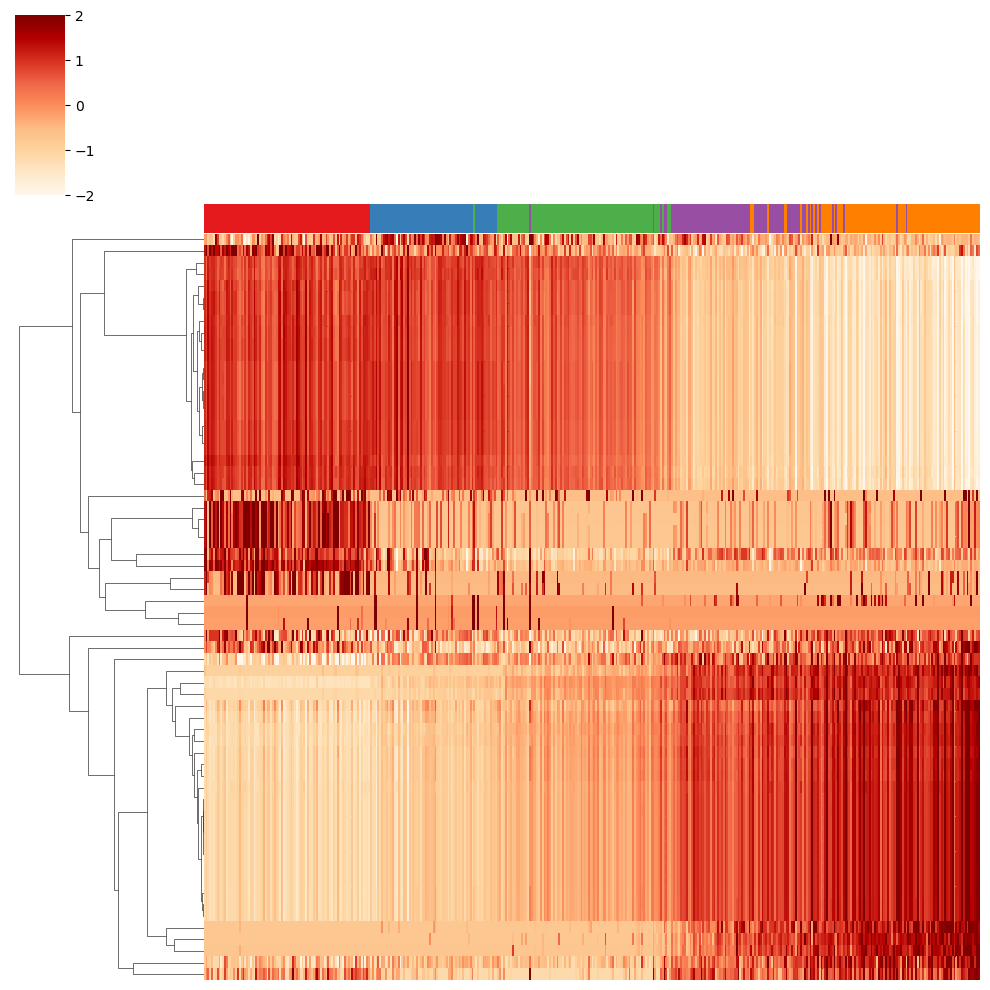

In [34]:
heatdata = adata.obsm['X_reg']
# heatdata = adata.X
heatdata = (heatdata - heatdata.mean(axis=0)) / heatdata.std(axis=0)
heatdata = heatdata.T
heatdata = np.clip(heatdata, -2, 2)
heatdata = heatdata[~np.isnan(heatdata).any(axis=1)]

colors = {k:v for k,v in zip(adata.obs.celltype.cat.categories, adata.uns['celltype_colors'])}
col_colors = adata.obs.celltype.apply(lambda x: colors[x]).to_numpy()

sns.clustermap(heatdata, col_cluster=False, 
               cmap="OrRd", col_colors=col_colors, 
               annot=False, xticklabels=[], yticklabels=[])
plt.show()

### NEXT
